# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## Подготовка данных

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

### Изучение данных

In [ ]:
df = pd.read_csv('/datasets/autos.csv')

In [ ]:
df.head(15)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [ ]:
df.describe(include=[object]).T

,count,unique,top,freq
DateCrawled,354369,271174,2016-03-24 14:49:47,7
VehicleType,316879,8,sedan,91457
Gearbox,334536,2,manual,268251
Model,334664,250,golf,29232
FuelType,321474,7,petrol,216352
Brand,354369,40,volkswagen,77013
NotRepaired,283215,2,no,247161
DateCreated,354369,109,2016-04-03 00:00:00,13719
LastSeen,354369,179150,2016-04-06 13:45:54,17


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
df.isna().mean().sort_values(ascending = False)

NotRepaired          0.200791
VehicleType          0.105794
FuelType             0.092827
Gearbox              0.055967
Model                0.055606
DateCrawled          0.000000
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Kilometer            0.000000
RegistrationMonth    0.000000
Brand                0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

## Предобработка данных

### Изменение названий столбцов:

In [ ]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower()for i in df.columns]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [ ]:
df.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 
         'postal_code', 'last_seen'], axis=1, inplace=True)
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'not_repaired'],
      dtype='object')

### Заполнение пропусков в данных

Выведем датафрейм и информацию о проценте пропусков в каждом столбце для более детального ознакомления с данными:

In [ ]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [ ]:
df.isna().mean().sort_values(ascending = False)

not_repaired         0.200791
vehicle_type         0.105794
fuel_type            0.092827
gearbox              0.055967
model                0.055606
price                0.000000
registration_year    0.000000
power                0.000000
kilometer            0.000000
brand                0.000000
dtype: float64

#### not_repaired

Пропуски в данном столбце можно обосновать тем, что если машина не ремонтировалась, хозяин мог просто пропустить данное поле, так что заменяем пропуски на значение 1, так же переведем категориальные данные в 0 и 1 для удобства.

In [ ]:
df['not_repaired'].value_counts()

no     247161
yes     36054
Name: not_repaired, dtype: int64

In [ ]:
df['not_repaired'] = df['not_repaired'].map({'yes':1, 'no':0}).fillna(0)

In [ ]:
df['not_repaired'].value_counts()

0.0    318315
1.0     36054
Name: not_repaired, dtype: int64

#### vehicle_type 

В данном столбце есть тип данных 'other', можно было бы все пропуски запонить данным значением, но я считаю это некорректным, так как мы не знаем, что под собой подразумевает данное обозначение. Заменяем пропуски на 'unknown'.

In [ ]:
df['vehicle_type'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

In [ ]:
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')

In [ ]:
df['vehicle_type'].value_counts()

sedan          91457
small          79831
wagon          65166
unknown        37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

#### fuel_type

Посмотрев на данные по виду топлива подробнее, можно заметить, что 2 самые популярные категории это обозначения одного вида топлива - бензина, только в америке и в англии. Устраним это, пропуски заменим значением 'unknown'.

In [ ]:
df['fuel_type'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [ ]:
df['fuel_type'] = df['fuel_type'].replace('petrol', 'gasoline')
df['fuel_type'].fillna('unknown', inplace=True)

In [ ]:
df['fuel_type'].value_counts()

gasoline    315072
unknown      32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

#### gearbox

Пропуски в данных о типе коробки передач заменим на 'unknown'.

In [ ]:
df['gearbox'].value_counts()

manual    268251
auto       66285
Name: gearbox, dtype: int64

In [ ]:
df['gearbox'] = df['gearbox'].fillna('unknown')

In [ ]:
df['gearbox'].value_counts()

manual     268251
auto        66285
unknown     19833
Name: gearbox, dtype: int64

#### model

В данном столбце, так же как и в столбце ***vehicle_type***, есть тип данных 'other' но заполнять этим значением пропуски мы не будем. Заменяем пропуски на 'unknown'.

In [ ]:
df['model'].value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 250, dtype: int64

есть other, но непонетно что они имели ввиду, так что анноун

In [ ]:
df['model'] = df['model'].fillna('unknown')

In [ ]:
df['model'].value_counts()

golf                  29232
other                 24421
3er                   19761
unknown               19705
polo                  13066
                      ...  
serie_2                   8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 251, dtype: int64

Проверяем, остались ли пропуски в данных:

In [ ]:
df.isna().mean().sort_values(ascending = False)

price                0.0
vehicle_type         0.0
registration_year    0.0
gearbox              0.0
power                0.0
model                0.0
kilometer            0.0
fuel_type            0.0
brand                0.0
not_repaired         0.0
dtype: float64

Теперь в данных отсутствуют пропуски, можно двигаться дальше

### Изучение редких значений и выбросов

In [ ]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,unknown,1993,manual,0,golf,150000,gasoline,volkswagen,0.0
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,1.0
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0.0
3,1500,small,2001,manual,75,golf,150000,gasoline,volkswagen,0.0
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0.0


Убирать редкие и выбивающиеся значения будем, опираясь на межквартильный размах, также построим диаграмму размаха для каждого из параметров для наглядности.

In [ ]:
def describe_hist_and_boxplot(data, column, title):
    display(data[column].describe())
    print('2,5й и 97,5й процентли:', data[column].quantile(0.025), ',', data[column].quantile(0.975), '\n')
    
    #Вычислим границы выбросов:
    # Первая квантиль
    Q1 = data[column].quantile(0.25)
    # Третья квантиль
    Q3 = data[column].quantile(0.75)
    # Межквантильное расстояние
    IQR = Q3 - Q1
    
    min_range = Q1 - 1.5 * IQR
    max_range = Q3 + 1.5 * IQR
    
    if min_range < 0:
        min_range = 0
    
    print('-' * 120, '\n') 
    print('Распределение и диаграмма размаха для параметра:', title)   
    
    data[column].plot(kind='hist', bins=50, range=(min_range, max_range), grid=True, title=title, figsize=(13,6), legend=True)
    plt.show()
    
    plt.ylim(min_range, max_range)
    data.boxplot(column=column)
    plt.show()

### price

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

2,5й и 97,5й процентли: 0.0 , 16900.0 

------------------------------------------------------------------------------------------------------------------------ 

Распределение и диаграмма размаха для параметра: Цена


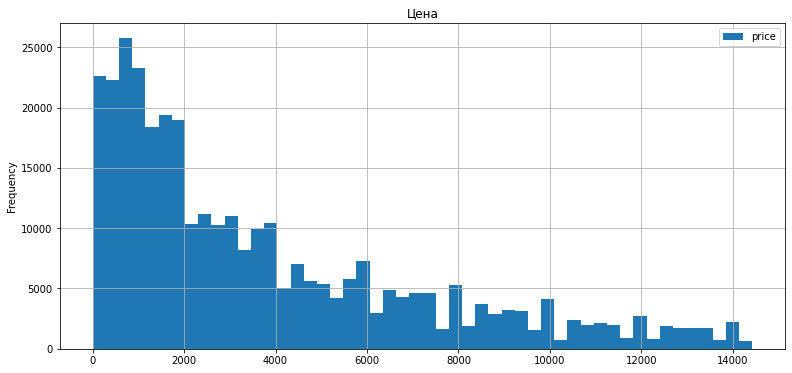

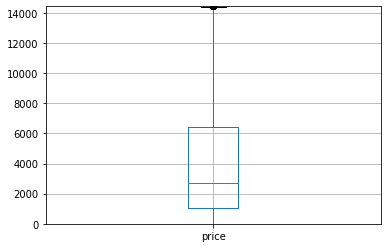

In [ ]:
describe_hist_and_boxplot(df, 'price', 'Цена')

Видно, что в данных много нулей. Бесплатно машины не продают, скорее всего это ошибки в данных, так как заказчику важна точность прогноза, то удалим эти данные. Также определим 0,05 и 0,95 квантили и оставим данные внутри этого интервала.

In [ ]:
print(df.query('price == 0').shape[0])

10772


In [ ]:
filtered_df = df.query('price != 0')
print(df.shape[0])
print(filtered_df.shape[0])

354369
343597


In [ ]:
filtered_df['price'].quantile([0.05, 0.95])

0.05      350.0
0.95    14800.0
Name: price, dtype: float64

In [ ]:
filtered_df = filtered_df.query('price >= 350 and price <= 14800')

count    310896.000000
mean       4080.479775
std        3534.369524
min         350.000000
25%        1300.000000
50%        2850.000000
75%        5990.000000
max       14800.000000
Name: price, dtype: float64

2,5й и 97,5й процентли: 450.0 , 13000.0 

------------------------------------------------------------------------------------------------------------------------ 

Распределение и диаграмма размаха для параметра: Цена


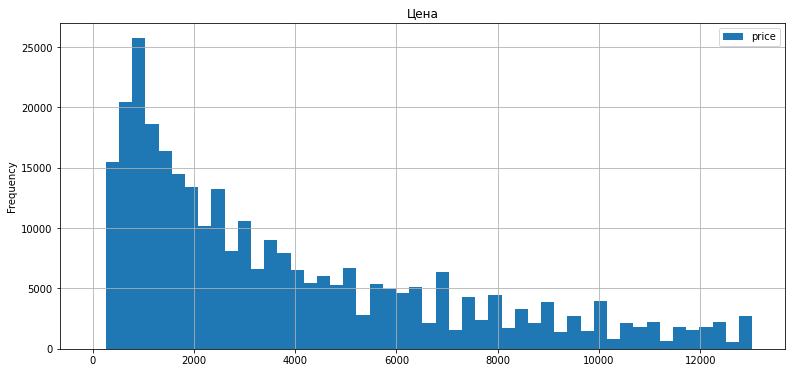

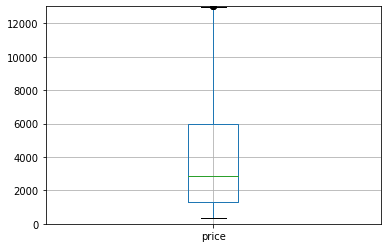

In [ ]:
describe_hist_and_boxplot(filtered_df, 'price', 'Цена')

### registration_year

count    310896.000000
mean       2003.738762
std          65.684292
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: registration_year, dtype: float64

2,5й и 97,5й процентли: 1989.0 , 2017.0 

------------------------------------------------------------------------------------------------------------------------ 

Распределение и диаграмма размаха для параметра: Год регистрации


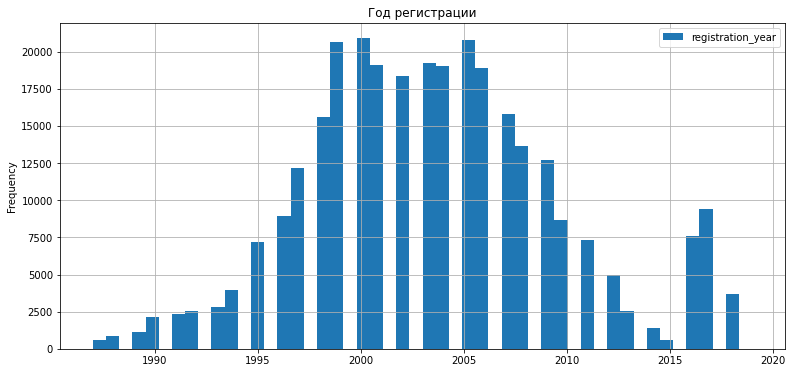

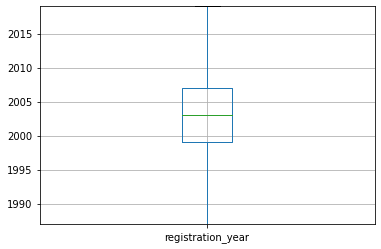

In [ ]:
describe_hist_and_boxplot(filtered_df, 'registration_year', 'Год регистрации')

Думаю логичным решением будет убрать все машины, старше 1970, так как скорее всего это слишком старые машины, которые в большинстве своем не работоспособны.

In [ ]:
print(filtered_df.query('registration_year < 1970 or registration_year > 2021').shape[0])

923


In [ ]:
filtered_df = filtered_df.query('registration_year >= 1970 and registration_year <= 2021')

### power

count    309973.000000
mean        109.903772
std         186.495437
min           0.000000
25%          71.000000
50%         105.000000
75%         140.000000
max       20000.000000
Name: power, dtype: float64

2,5й и 97,5й процентли: 0.0 , 231.0 

------------------------------------------------------------------------------------------------------------------------ 

Распределение и диаграмма размаха для параметра: Мощность двигателя


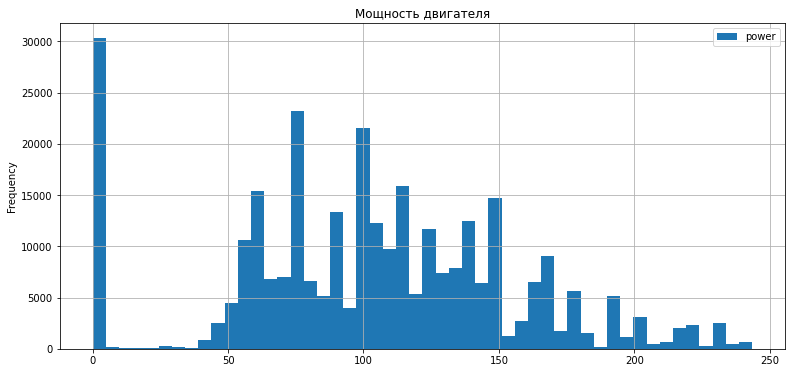

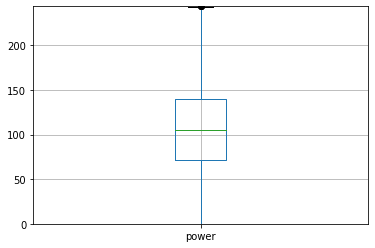

In [ ]:
describe_hist_and_boxplot(filtered_df, 'power', 'Мощность двигателя')

Машин, с мощностью меньше 10 л.с. не существует, также значения мощности больше 1000 л.с. являются выбросами.

In [ ]:
print(filtered_df.query('power >= 1000').shape[0])
print(filtered_df.query('power <= 10').shape[0])

259
30442


In [ ]:
filtered_df = filtered_df.query('power > 10 and power < 1000')

count    279272.000000
mean        118.157907
std          51.160331
min          11.000000
25%          75.000000
50%         110.000000
75%         143.000000
max         999.000000
Name: power, dtype: float64

2,5й и 97,5й процентли: 50.0 , 232.0 

------------------------------------------------------------------------------------------------------------------------ 

Распределение и диаграмма размаха для параметра: Мощность двигателя


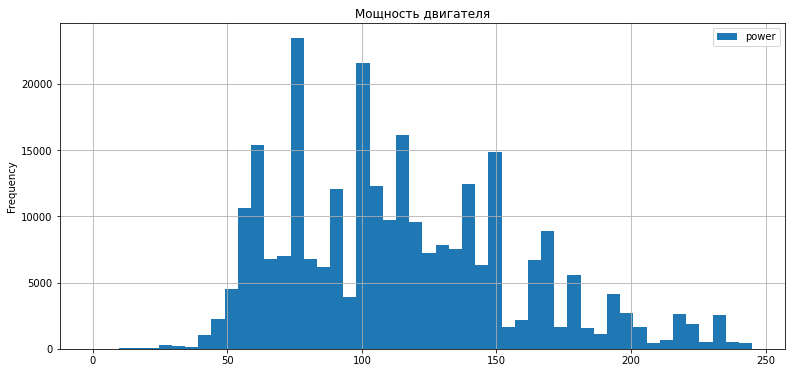

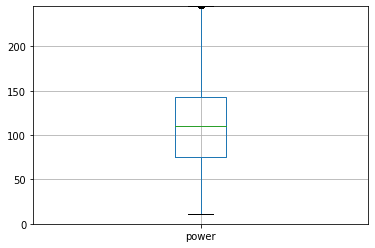

In [ ]:
describe_hist_and_boxplot(filtered_df, 'power', 'Мощность двигателя')

### kilometer

count    279272.000000
mean     130393.200894
std       34845.404803
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

2,5й и 97,5й процентли: 30000.0 , 150000.0 

------------------------------------------------------------------------------------------------------------------------ 

Распределение и диаграмма размаха для параметра: Пробег


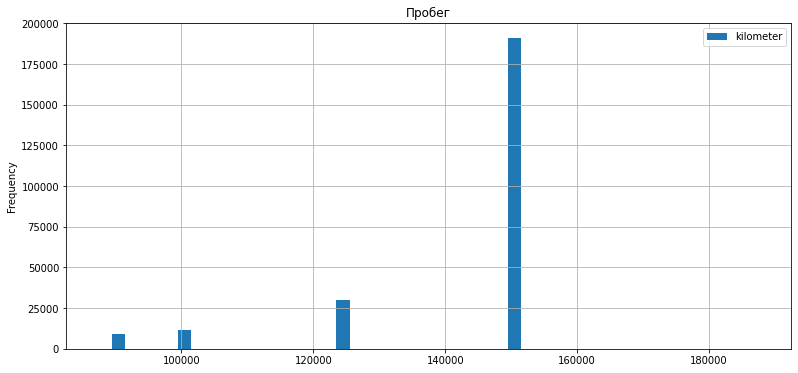

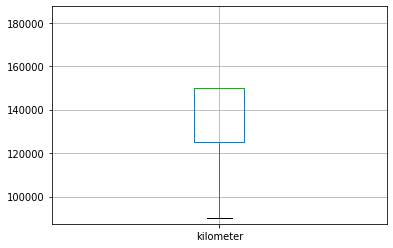

In [ ]:
describe_hist_and_boxplot(filtered_df, 'kilometer', 'Пробег')

Данные по пробегу выглядят нормально.

## Обучение моделей

Изучим 3 модели машинного обучения:
1. Линейная регрессия
2. LightGBM
3. CatBoost

### Подготовка данных к обучению

#### Скопируем датафрейм для моделей catboost и lightgbm без перевода категориальных данных в числовые, так как обе модели поддерживают работу с категориальными данными.

Сделаем копию датасета для моделей CatBoost и LightGBM

In [ ]:
df_for_ctb_and_lgbm = filtered_df.copy()
df_for_ctb_and_lgbm.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0.0
3,1500,small,2001,manual,75,golf,150000,gasoline,volkswagen,0.0
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0.0
5,650,sedan,1995,manual,102,3er,150000,gasoline,bmw,1.0
6,2200,convertible,2004,manual,109,2_reihe,150000,gasoline,peugeot,0.0


#### Преобразование категориальных признаков в численные с помощью OHE, с защитой от дамми-ловушки.

In [ ]:
filtered_df = pd.get_dummies(df, drop_first=True)

In [ ]:
filtered_df.head()

,price,registration_year,power,kilometer,not_repaired,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,...,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
0,480,1993,0,150000,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,18300,2011,190,125000,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9800,2004,163,125000,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75,150000,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,3600,2008,69,90000,0.0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
filtered_df.shape

(354369, 310)

#### Разбиение данных на выборки

In [ ]:
target = filtered_df['price']
features = filtered_df.drop('price', axis=1)

In [ ]:
features_train, features_valid_and_test, target_train, target_valid_and_test = train_test_split(features, target, 
                                                                             test_size=0.40, random_state=244466666)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_and_test, target_valid_and_test, 
                                                                             test_size=0.50, random_state=244466666)

In [ ]:
print(features_train.shape[0], features_valid.shape[0], features_test.shape[0])
print(target_train.shape[0], target_valid.shape[0], target_test.shape[0])

212621 70874 70874
212621 70874 70874


#### Стандартизация численных признаков с помощью StandardScaler.

In [ ]:
numeric = ['registration_year', 'power', 'kilometer']

In [ ]:
features_train[numeric].head()

,registration_year,power,kilometer
146020,1998,170,150000
314562,2001,109,150000
292708,2005,54,150000
238266,2001,185,150000
234302,2006,163,150000


In [ ]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [ ]:
features_train[numeric].head()

,registration_year,power,kilometer
146020,-0.067060,0.329018,0.576096
314562,-0.035361,-0.004435,0.576096
292708,0.006905,-0.305089,0.576096
238266,-0.035361,0.411014,0.576096
234302,0.017471,0.290753,0.576096


### Датафрейм для результатов

In [ ]:
info_df = []

In [ ]:
def add_info_df(title='', fit_time='', pred_time='', rmse=''):
    info_df.append({'Модель': title,
                'Время обучения': fit_time, 'Время предсказаний': pred_time, 
                'RMSE': rmse})

### Линейная регрессия


In [ ]:
start = time.time()
linear_regression_model = LinearRegression()
linear_regression_model.fit(features_train, target_train)
lr_fit_time = time.time() - start
print(lr_fit_time)

19.419528484344482


In [ ]:
start = time.time()
predicted_values = linear_regression_model.predict(features_valid)
lr_prediction_time = time.time() - start
lr_rmse = mean_squared_error(target_valid, predicted_values) ** 0.5
print('RMSE:', lr_rmse)
print(lr_prediction_time)

RMSE: 3297.9069362698688
0.129044771194458


In [ ]:
add_info_df('LinearRegression', lr_fit_time, lr_prediction_time, lr_rmse)
display(pd.DataFrame(info_df))

,Модель,Время обучения,Время предсказаний,RMSE
0,LinearRegression,19.419528,0.129045,3297.906936


### CatBoost

In [ ]:
df_for_ctb_and_lgbm.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0.0
3,1500,small,2001,manual,75,golf,150000,gasoline,volkswagen,0.0
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0.0
5,650,sedan,1995,manual,102,3er,150000,gasoline,bmw,1.0
6,2200,convertible,2004,manual,109,2_reihe,150000,gasoline,peugeot,0.0


Приведем категориальные признаки к нужному типу:

In [ ]:
categorical = ['vehicle_type','gearbox','model','fuel_type','brand']

In [ ]:
df_for_ctb_and_lgbm[categorical] = df_for_ctb_and_lgbm[categorical].astype('category')

In [ ]:
features = df_for_ctb_and_lgbm.drop('price', axis=1)
target = df_for_ctb_and_lgbm['price']

features_train, features_valid_and_test, target_train, target_valid_and_test = train_test_split(features, target, 
                                                                             test_size=0.40, random_state=244466666)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_and_test, target_valid_and_test, 
                                                                             test_size=0.50, random_state=244466666)
#Размеры обучающей и тестовой выборки
print('Размер обучающей выборки с категориальными данными: {} объектов, {} признаков'.format(features_train.shape[0], features_train.shape[1]))
print('Размер валидационной выборки с категориальными данными: {} объектов, {} признаков'.format(features_valid.shape[0], features_valid.shape[1]))
print('Размер тестовой выборки с категориальными данными: {} объектов, {} признаков'.format(features_test.shape[0], features_test.shape[1]))

Размер обучающей выборки с категориальными данными: 167563 объектов, 9 признаков
Размер валидационной выборки с категориальными данными: 55854 объектов, 9 признаков
Размер тестовой выборки с категориальными данными: 55855 объектов, 9 признаков


In [ ]:
df_for_ctb_and_lgbm.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0.0
3,1500,small,2001,manual,75,golf,150000,gasoline,volkswagen,0.0
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0.0
5,650,sedan,1995,manual,102,3er,150000,gasoline,bmw,1.0
6,2200,convertible,2004,manual,109,2_reihe,150000,gasoline,peugeot,0.0


In [ ]:
# %%time

# model = CatBoostRegressor(loss_function='RMSE', cat_features=categorical)
# parametrs = {'iterations': range(1, 502, 100), 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8], 'depth': range(1, 71, 10)}
# grid_cbr = GridSearchCV(model, parametrs, cv=5, verbose=False)
# grid_cbr.fit(features_train, target_train)
# grid_cbr.best_params_

{'depth': 11, 'iterations': 501, 'learning_rate': 0.2}

In [ ]:
start = time.time()
cb_model = CatBoostRegressor(loss_function='RMSE', cat_features=categorical, iterations=501, learning_rate=0.2, depth=11, verbose=100)                      
cb_model.fit(features_train, target_train)
cb_fit_time = time.time() - start
print(cb_fit_time)                            

0:	learn: 3088.0058412	total: 525ms	remaining: 4m 22s
100:	learn: 1293.9268254	total: 39.4s	remaining: 2m 36s
200:	learn: 1213.5356200	total: 1m 18s	remaining: 1m 57s
300:	learn: 1166.1672505	total: 1m 59s	remaining: 1m 19s
400:	learn: 1132.8319205	total: 2m 40s	remaining: 40s
500:	learn: 1107.7342830	total: 3m 21s	remaining: 0us
204.10300469398499


In [ ]:
start = time.time()
predicted_values = cb_model.predict(features_valid)
cb_prediction_time = time.time() - start
cb_rmse = mean_squared_error(target_valid, predicted_values) ** 0.5
print('RMSE:', cb_rmse)
print(cb_prediction_time)

RMSE: 1323.2426033931592
0.5542361736297607


In [ ]:
add_info_df('CatBoost', cb_fit_time, cb_prediction_time, cb_rmse)
display(pd.DataFrame(info_df))

,Модель,Время обучения,Время предсказаний,RMSE
0,LinearRegression,19.419528,0.129045,3297.906936
1,CatBoost,204.103005,0.554236,1323.242603


### LightGBM

In [ ]:
# %%time

# model = lgb.LGBMRegressor(metric='rmse', random_state=244466666)
# parametrs = {'max_depth': range(1, 31, 5), 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 'n_estimators': range(1, 502, 100)}
# grid_lgb = GridSearchCV(model, parametrs, cv=5, verbose=False)
# grid_lgb.fit(features_train, target_train)
# grid_lgb.best_params_

{'learning_rate': 0.2, 'max_depth': 11, 'n_estimators': 501}

In [ ]:
start = time.time()
lgbm_model = lgb.LGBMRegressor(metric='rmse', random_state=244466666, learning_rate=0.2, max_depth=11, n_estimators=501)                      
lgbm_model.fit(features_train, target_train)
lgbm_fit_time = time.time() - start
print(lgbm_fit_time) 

20.734085083007812


In [ ]:
start = time.time()
predicted_values = lgbm_model.predict(features_valid)
lgbm_prediction_time = time.time() - start
lgbm_rmse = mean_squared_error(target_valid, predicted_values) ** 0.5
print('RMSE:', lgbm_rmse)
print(lgbm_prediction_time)

RMSE: 1322.0227397875112
1.899339199066162


In [ ]:
add_info_df('LightGBM', lgbm_fit_time, lgbm_prediction_time, lgbm_rmse)
display(pd.DataFrame(info_df))

,Модель,Время обучения,Время предсказаний,RMSE
0,LinearRegression,19.419528,0.129045,3297.906936
1,CatBoost,204.103005,0.554236,1323.242603
2,LightGBM,20.734085,1.899339,1322.022740


## Анализ моделей

In [ ]:
display(pd.DataFrame(info_df))

,Модель,Время обучения,Время предсказаний,RMSE
0,LinearRegression,19.419528,0.129045,3297.906936
1,CatBoost,204.103005,0.554236,1323.242603
2,LightGBM,20.734085,1.899339,1322.022740


В ходе работы над проектом были сделаны следующие выводы:

- Наилучшие модели LightGBM и CatBoost, они показали наименьшиую RMSE, в 2.5 раза меньше, чем у модели линейной регрессии 
- Время обучения меньше у LightGBM 
- Время предсказаний меньше у CatBoost 
- Точность предсказаний лучше у LightGBM 
 
Стоит уточнить у заказчика, какой именно параметр ему важнее:

- Eсли наиболее важными являются время обучения и точность, то стоит использовать LightGBM
- Eсли наиболее важна скорость предсказаний, а скорость обучения не так важна, то можно использовать CatBoost
- Eсли наиболее важными являются скорость предсказаний и скорость обучения, то лучше выбрать LightGBM

Итоговой моделью я бы выбрал CatBoost, так как ее сочетание скорости и точности мне кажется оптимальным, проверим качество этой модели на тестовой выборке:

In [ ]:
predicted_values = cb_model.predict(features_test)
cb_rmse = mean_squared_error(target_test, predicted_values) ** 0.5
print('RMSE:', cb_rmse)

RMSE: 1316.5188151767456


Значение RMSE нас устраивает, можно применять эту модель для определения стоимости автомобилей.